## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working on the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import my libraries.

In [91]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [92]:
# Read data and explore
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [93]:
# more info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Find the number of rows in the dataset.

In [94]:
# The number of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [95]:
# The number of unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [96]:
# The proportion of users converted
round(df['converted'].mean(),4)

0.1197

e. The number of times the `new_page` and `treatment` don't match.

In [97]:
# The number of times the new_page and treatment don't mathch
df.query('group == "treatment" & landing_page == "old_page" or group == "control" & landing_page == "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [98]:
# The number of rows with missing values
df['user_id'].isna().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Create a new dataset. Store your new dataframe in **df2**.

In [99]:
# create a new dataframe where treatment matches new page and control matches
# old page.
df2=df.query('group == "treatment" & landing_page == "new_page"')
df2=df2.append(df.query('group == "control" & landing_page == "old_page"'))         

In [100]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [101]:
# Number of unique ids in df2
df2.nunique().user_id

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [102]:
# identify user id for duplicated value in df2
df2[df2['user_id'].duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [103]:
# row information for duplicated value
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [104]:
# inspect the rows with duplicated value
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep my dataframe as **df2**.

In [105]:
# drop duplicated value with 2893 index
df2 = df2.drop(2893)

In [106]:
# check dataframe for duplicated values
df2[df2['user_id'].duplicated() == True].count().user_id

0

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [107]:
# probability of converting
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [108]:
# probability of converting in the control group
df2[df2['group']=="control"]['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [109]:
# probability of converting in the treatment group
df2[df2['group']=="treatment"]['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [110]:
# probability of receiving new page
df2[df2['landing_page']=="new_page"].shape[0] / df2.shape[0]

0.5000619442226688

e.

**There is not enough evidence to conclude such conclusion. One aggregate result such as mean can't be a good estimate of comparison between two groups since the distribution of data for both is not considered.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.`

**Null hypothesis: The number of converted individuals receiving new page is equal or smaller than the number of converted individuals receiving old page.
$$ p_{old} \geq p_{new} $$ <br>
Alternative hypotheis: The number of converted individuals receiving new page is greater than the number of converted individuals receiving old page.<br>
$$ p_{old} \lt p_{new} $$**

`2.`

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [111]:
# conversion rate under the null for new pages
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [112]:
# conversion rate under the null for old pages
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [113]:
# number of individuals in the treatment group or new pages
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [114]:
# number of individuals in the control group or old pages
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [115]:
# simulate n_new transactions under the null with p_new probability. Probability 
# of converted should be p_new.
new_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_converted

array([0, 0, 0, ..., 1, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [116]:
# simulate n_new transactions under the null with p_old probability. Probability 
# of converted should be p_old.
old_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
old_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [117]:
# The difference between simulated new and old values
obs_diff=new_converted.mean()-old_converted.mean()
obs_diff

-0.00094515074216643125

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [118]:
# create distribuation of difference of simulated p_new and p_old and store as
# p_diffs array
p_diffs=[]
for _ in range(10000):
    new_page_simulate=np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
    old_page_simulate=np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_simulate.mean()-old_page_simulate.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

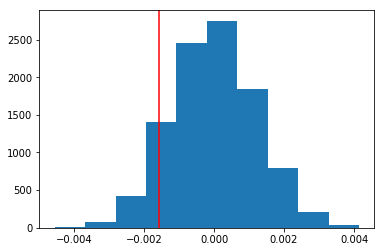

In [119]:
# draw p_diffs histogram and draw the line of the difference betwen simulated
# p_new and p_old
plt.hist(p_diffs);
plt.axvline(x=actual_diffs,color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [120]:
# The proportion of p_diffs greater than the actual difference observed in population
actual_diffs=df2.query('group=="treatment"')['converted'].mean()-df2.query('group=="control"')['converted'].mean()
actual_diffs
(p_diffs>actual_diffs).mean()

0.90590000000000004

k.

**It is called p-value. It means that if this value is high enough it is more likely that we have observed our statistic from the null and more chance of error to choose alternative hypothesis. The thershold to reject the null hypotheis is usually set to 0.05 and if our p-value is larger than this, we fail to reject our null hypothesis and more likely to choose alternative hypothesis by error so we stick to null hence <br>
$$ p_{old} \geq p_{new} $$**

l. I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [121]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control']['converted'].sum()
convert_new = df2[df2['group'] == 'treatment']['converted'].sum()
n_old = df2[df2['landing_page'] == 'old_page']['converted'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page']['converted'].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [122]:
# calculate z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The results from built_in are in agreement witht the previous results. The p-value calculated from built-in is 0.905 and larger than 0.05 threshold. There is no evidence that the conversion rates for treatment group receiving new pages is higher compared to the conversion rate for control group receiving old pages. We fail to reject the null hypothesis hence $$ p_{old} \geq p_{new} $$**

In [123]:
# calculate the critical z-score for 95% confidence interval
from scipy.stats import norm
norm.ppf(0.05/2),norm.ppf(1-(0.05/2))

(-1.9599639845400545, 1.959963984540054)

**The z-score is also equal to -1.31 and between the critical values of -1.95 and 1.95. We again fail to reject the null hypothesis according to this observation.**

<a id='regression'></a>
### Part III - A regression approach

`1.`

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [124]:
df2['intercept']=1
df2[['control','treatment']]=pd.get_dummies(df2['group'])
df2['ab_page']=df2['treatment']
df2.drop(df2[['control','treatment']], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [125]:
import statsmodels.api as sm
log_reg=sm.Logit(df2['converted'], df2[['intercept','ab_page']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [126]:
log_reg

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        02:14:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p_value associated with ab_page is 0.19. This is a two-tailed test compared to the results in part II which was one-tailed. In part II we failed to reject the null hypothesis and concluded that the effect of old pages on conversion rate is equal or greater than the effect of new pages on conversion rate. Here, We also fail to reject our null hypothesis which is $$H_{0}: P_{new}-P_{old}=0$$ and conclude that ab_page has no significant effect on conversion rates. As a result, treatment group doesn't have significant difference in conversion rate compared to control group.
The null hypothesis for the regression model is that ab_page has no significant effect on conversion rate. The alternative hypothesis is that ab_page has significant effect on conversion rate. $$H_{1}: P_{new}-P_{old} \neq 0$$**

f.

**Adding more variables to the regression model can increase its predictibility and the bahaviour of the model can be explained with higher confidence for prediction of dependednt variable. The issues associated with more variables in the model would be parsimony and introduction of multicolinearity and confounding between variables meaning that the dependent variable can be indirectly affected by a variable which directly affects another variable.**

g.

In [127]:
# read countries dataset
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [128]:
# merge countries dataset to df2
df_join=df2.join(df_country.set_index('user_id'), on='user_id')
df_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [129]:
# create intercept and dummy variables columns
df_join['intercept']=1
df_join[['CA','UK','US']]=pd.get_dummies(df_join['country'])
df_join.drop(df_join[['country']], axis=1, inplace=True)
df_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,0


In [130]:
# run logistic regression
logit_count=sm.Logit(df_join['converted'], df_join[['intercept','ab_page','CA','UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [131]:
logit_count

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Jul 2019   Pseudo R-squ.:               2.323e-05
Time:                        02:14:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**The countries have no significant effect on conversion rate. The p value for the likelihood of the effect of ab_page was not impacted by the countries.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [132]:
# create new interaction columns between countries and ab_page meaning that if the value in the column
# is 1 the person have received new page and lived in that country
df_join['CA_interact']=df_join['CA']*df_join['ab_page']
df_join['UK_interact']=df_join['UK']*df_join['ab_page']
df_join['US_interact']=df_join['US']*df_join['ab_page']
df_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_interact,UK_interact,US_interact
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,0,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,0,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,0,1,0,0


In [133]:
# run logistic regression for the interaction between page and countries
logit_count2=sm.Logit(df_join['converted'], df_join[['intercept','ab_page','CA_interact','UK_interact']]).fit().summary()
logit_count2

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 16 Jul 2019   Pseudo R-squ.:               3.351e-05
Time:                        02:14:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page        -0.0183      0.013     -1.449      0.147      -0.043       0.006
CA_interact    -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK_interact     0.0257      0.019      1.363      0.173      -0.011       0.063
===============================================================================
"""

** No significant results from the likelihood of the effect of the interaction of both country and page were observed below p-value=0.05. We again fail to reject the null hypothesis.**

<a id='conclusions'></a>
## Conclusion

**Based on all results from A/B testing and logistic regression we can be certain that the introduction of new page doesn't significantly increase conversion rate in individuals. The company should think of a different page design which should be tested again to achieve statistically and practically significant results which lead to higher conversion rates from the application of the aforementioned alternative new page.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [134]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0